# sentieon metrics

In [92]:
import os
import pandas as pd
import numpy as np
import boto3
from pathlib import Path
from statistics import mean, median
from scipy.interpolate import interp1d
from scipy import stats
import math

import hashlib

import pprint
pp = pprint.PrettyPrinter(indent=4)

from datetime import date

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import display, HTML

plt.rcParams['hatch.linewidth'] = 0.25

%matplotlib inline

pp = pprint.PrettyPrinter(indent=4)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.facecolor'] = 'w'

from collections import defaultdict

pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
print(cwd)

/home/bryan/git/AvidityManuscript2023/notebooks


In [93]:
reference = "Homo_sapiens_assembly38"
catalog = "GRCh38_SimpleRepeat_homopolymer_gt11_slop5"

slop = 5

In [94]:
pdf = False

home_dir = Path.home()
work_dir = os.path.join(home_dir,"AvidityManuscript2023/analysis/homopolymer-offset-error/")

! mkdir -p $work_dir


In [108]:
read_stacks = {}
homopolymer_tsv_path = os.path.abspath(os.path.join(cwd,"..","data","homopolymer-error",catalog))
print(homopolymer_tsv_path)

for file in os.listdir(homopolymer_tsv_path):
    
    wflow_id = os.path.basename(file).replace(".offset-error.tsv","").replace(".interval-error.tsv","").replace("__offset-error","").replace("__interval-error","")
    
    if file.endswith(".offset-error.tsv"):
        
        if wflow_id not in read_stacks:
            read_stacks[wflow_id] = {}
            
        read_stacks[wflow_id]["offset_error"] = os.path.join(homopolymer_tsv_path,file)
    
    if file.endswith(".interval-error.tsv"):
        
        if wflow_id not in read_stacks:
            read_stacks[wflow_id] = {}
            
        read_stacks[wflow_id]["interval_error"] = os.path.join(homopolymer_tsv_path,file)
        
print("")
print(f"found {len(read_stacks)} offset error tsvs")

workflows = []
for wflow_id in read_stacks:
    
    wflow_arr = wflow_id.split("__")
    
    run_id = wflow_id
    lirbary_id,fqd,run_catalog,file_type = None,None,None,None
    
    if len(wflow_arr) == 3:
        run_id,fqd,run_catalog = wflow_arr
    elif len(wflow_arr) == 4:
        run_id,lirbary_id,fqd,run_catalog = wflow_arr
    
    wflow_read_stack = read_stacks[wflow_id]
    
    print("",run_id,sep="\t")
    print("","",wflow_read_stack.get("offset_error",None),sep="\t")
    print("","",wflow_read_stack.get("interval_error",None),sep="\t")
    
    #assert catalog == run_catalog
    
    tag="AVITI"
    provider="elembio"
    if "novaseq" in wflow_id:
        tag="NovaSeq6000"
        provider="illumina"
    if "Lotus" in wflow_id:
        tag="NextSeq2000"
        provider="illumina"
    
    workflow = {
        "wflow_id": wflow_id,
        "tag": tag,
        "provider": provider,
        "catalog": run_catalog,
        "read_stack": wflow_read_stack
    }

    workflows.append(workflow)

# sort workflows
sort_order = ["tag"]
workflows = sorted(workflows, key=lambda item: [item.get(t) for t in sort_order], reverse=False)

print("")
print(f"workflows [{len(workflows)}]")
for wflow in workflows:
    print("",wflow["wflow_id"],wflow["tag"],sep="\t")

/home/bryan/git/AvidityManuscript2023/data/homopolymer-error/GRCh38_SimpleRepeat_homopolymer_gt11_slop5

found 3 offset error tsvs
	20220601_PLT-03_BBS-0174-OBPA
		/home/bryan/git/AvidityManuscript2023/data/homopolymer-error/GRCh38_SimpleRepeat_homopolymer_gt11_slop5/20220601_PLT-03_BBS-0174-OBPA__FQD-2x150-35x__GRCh38_SimpleRepeat_homopolymer_gt11_slop5__offset-error.offset-error.tsv
		/home/bryan/git/AvidityManuscript2023/data/homopolymer-error/GRCh38_SimpleRepeat_homopolymer_gt11_slop5/20220601_PLT-03_BBS-0174-OBPA__FQD-2x150-35x__GRCh38_SimpleRepeat_homopolymer_gt11_slop5__interval-error.interval-error.tsv
	test__GRCh38_SimpleRepeat_homopolymer_gt11_slop5
		/home/bryan/git/AvidityManuscript2023/data/homopolymer-error/GRCh38_SimpleRepeat_homopolymer_gt11_slop5/test__GRCh38_SimpleRepeat_homopolymer_gt11_slop5.offset-error.tsv
		/home/bryan/git/AvidityManuscript2023/data/homopolymer-error/GRCh38_SimpleRepeat_homopolymer_gt11_slop5/test__GRCh38_SimpleRepeat_homopolymer_gt11_slop5.inter

In [109]:
def read_offset_error(wflow_id, wflow, offset_error_file):

    print("offset_error",wflow_id,sep="\t")

    error_range = 0.001
    min_observations = 30 * (1 / error_range)

    # calculate window
    pre_span, post_span = {}, {}
    with open(offset_error_file) as in_fh:
        for line in in_fh:
            line = line.strip()
            chrom,pos,n_errors,n_bases,error_rate = line.split("\t")
            pos, n_errors, n_bases, error_rate = int(pos), int(float(n_errors)), int(float(n_bases)), float(error_rate)

            if pos < 0:
                pre_span[pos] = pre_span.get(pos, 0) + 1
            if pos > 0:
                post_span[pos] = post_span.get(pos, 0) + 1

    pre_max = max(abs(pos) for pos,count in pre_span.items() if count >= 22)

    post_max = max(pos for pos,count in post_span.items() if count >= 22)


    print(pre_max, post_max, sep="\t")

    pre_mismatch_by_pos = np.zeros(pre_max, dtype="int")
    pre_weight_by_pos = np.zeros(pre_max, dtype="int")
    post_mismatch_by_pos = np.zeros(post_max, dtype="int")
    post_weight_by_pos = np.zeros(post_max, dtype="int")

    # read offset error
    dat = []
    with open(offset_error_file) as in_fh:
        for line in in_fh:
            line = line.strip()
            chrom,pos,n_errors,n_bases,error_rate = line.split("\t")
            pos, n_errors, n_bases, error_rate = int(pos), int(float(n_errors)), int(float(n_bases)), float(error_rate)

            if pos < 0:
                if abs(pos) >= pre_max:
                    continue
                pre_mismatch_by_pos[pos+pre_max] += n_errors
                pre_weight_by_pos[pos+pre_max] += n_bases
            else:
                if pos >= post_max:
                    continue
                post_mismatch_by_pos[pos] += n_errors
                post_weight_by_pos[pos] += n_bases

    pre_error_by_pos = np.zeros(pre_max, dtype="float")
    post_error_by_pos = np.zeros(post_max, dtype="float")
    pre_error_by_pos = (pre_mismatch_by_pos / pre_weight_by_pos) * 100
    post_error_by_pos = (post_mismatch_by_pos / post_weight_by_pos) * 100

    for pos,mismatch,weight,error in zip(np.arange(-pre_max, 0, dtype=int),pre_mismatch_by_pos,pre_weight_by_pos,pre_error_by_pos):

        if weight < min_observations:
            mismatch,weight,error = None,None,None

        dat.append(
                {
                    "wflow_id": wflow_id,
                    "tag":  wflow["tag"],
                    "provider":  wflow["provider"],
                    "catalog": wflow["catalog"],
                    "pos": pos,
                    "type": "pre",
                    "mismatch": mismatch,
                    "weight": weight,
                    "error_rate": error
                }
            )

    for pos,mismatch,weight,error in zip(np.arange(1, post_max+1, dtype=int),post_mismatch_by_pos,post_weight_by_pos,post_error_by_pos):

        if weight < min_observations:
            mismatch,weight,error = None,None,None

        dat.append(
                {
                    "wflow_id": wflow_id,
                    "tag":  wflow["tag"],
                    "provider":  wflow["provider"],
                    "catalog": wflow["catalog"],
                    "pos": pos,
                    "type": "post",
                    "mismatch": mismatch,
                    "weight": weight,
                    "error_rate": error
                }
            )


    df = pd.DataFrame(dat)

    return df

def read_interval_error(wflow_id, wflow, interval_error_file):

    print("interval_error",wflow_id,sep="\t")

    dat = []
    with open(interval_error_file) as in_fh:
        for i,line in enumerate(in_fh):
            line = line.strip()

            interval,interval_coord,pre_coverage,pre_mismatch,pre_base,pre_error,post_coverage,post_mismatch,post_base,post_error = line.split("\t")
            pre_coverage,pre_mismatch,pre_base,pre_error,post_coverage,post_mismatch,post_base,post_error = float(pre_coverage),int(pre_mismatch),int(pre_base),float(pre_error),float(post_coverage),int(post_mismatch),int(post_base),float(post_error)

            # skip nan entries
            if math.isnan(pre_error) or math.isnan(post_error):
                continue

            chrom,positions = interval_coord.split(":")
            start,end = positions.split("-")
            interval_length = int(end)-int(start)

            dat.append(
                {
                    "wflow_id": wflow_id,
                    "tag":  wflow["tag"],
                    "provider":  wflow["provider"],
                    "catalog": wflow["catalog"],
                    "interval": interval,
                    "interval_coord": interval_coord,
                    "interval_length": interval_length,
                    "pre_coverage": pre_coverage,
                    "pre_mismatch": pre_mismatch,
                    "pre_base": pre_base,
                    "pre_error": pre_error,
                    "post_coverage": post_coverage,
                    "post_mismatch": post_mismatch,
                    "post_base": post_base,
                    "post_error": post_error
                }
            )

    if len(dat) == 0:
        return pd.DataFrame()

    df = pd.DataFrame(dat).set_index("interval")

    return df

# process offset-error
offset_error_df = pd.concat({wflow["wflow_id"]:read_offset_error(wflow["wflow_id"], wflow, wflow["read_stack"]["offset_error"]) for wflow in workflows}, axis=0)
#with pd.option_context('display.max_rows', 5, 'display.max_columns', None, ):
#    display(offset_error_df)

# process interval-error
interval_error_df = pd.concat({wflow["wflow_id"]:read_interval_error(wflow["wflow_id"], wflow, wflow["read_stack"]["interval_error"]) for wflow in workflows}, axis=0)
#with pd.option_context('display.max_rows', 5, 'display.max_columns', None, ):
#    display(interval_error_df)



offset_error	20220601_PLT-03_BBS-0174-OBPA__FQD-2x150-35x__GRCh38_SimpleRepeat_homopolymer_gt11_slop5
143	148
offset_error	test__GRCh38_SimpleRepeat_homopolymer_gt11_slop5
143	148
offset_error	HG002.novaseq.pcr-free.50x__FQD-2x150-35x__GRCh38_SimpleRepeat_homopolymer_gt11_slop5
144	146
interval_error	20220601_PLT-03_BBS-0174-OBPA__FQD-2x150-35x__GRCh38_SimpleRepeat_homopolymer_gt11_slop5
interval_error	test__GRCh38_SimpleRepeat_homopolymer_gt11_slop5
interval_error	HG002.novaseq.pcr-free.50x__FQD-2x150-35x__GRCh38_SimpleRepeat_homopolymer_gt11_slop5


In [110]:
tmp_offset_error_df = offset_error_df.dropna(subset=['mismatch'])[["wflow_id","type","pos"]]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
#    display(tmp_offset_error_df)

max_pre_all = max(tmp_offset_error_df[tmp_offset_error_df.type == "pre"].groupby(["wflow_id"]).min()["pos"])
max_post_all = min(tmp_offset_error_df[tmp_offset_error_df.type == "post"].groupby(["wflow_id"]).max()["pos"])

print(max_pre_all, max_post_all, sep="\t")

offset_error_df = offset_error_df[((offset_error_df.type == "pre") & (offset_error_df.pos > max_pre_all)) | ((offset_error_df.type == "post") & (offset_error_df.pos < max_post_all))]

-127	116


In [111]:
hue="tag"
mean_error = offset_error_df.drop(columns=["pos","mismatch","weight"]).groupby(["tag","type"]).mean()
with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
    display(mean_error)

mean_error.to_excel(os.path.join(work_dir,f"mean-offset-error-by-{hue}__{catalog}.xlsx"))

error_rate
tag         type            
AVITI       post    0.447699
            pre     0.196313
NovaSeq6000 post    2.921509
            pre     0.271760

wflow_id


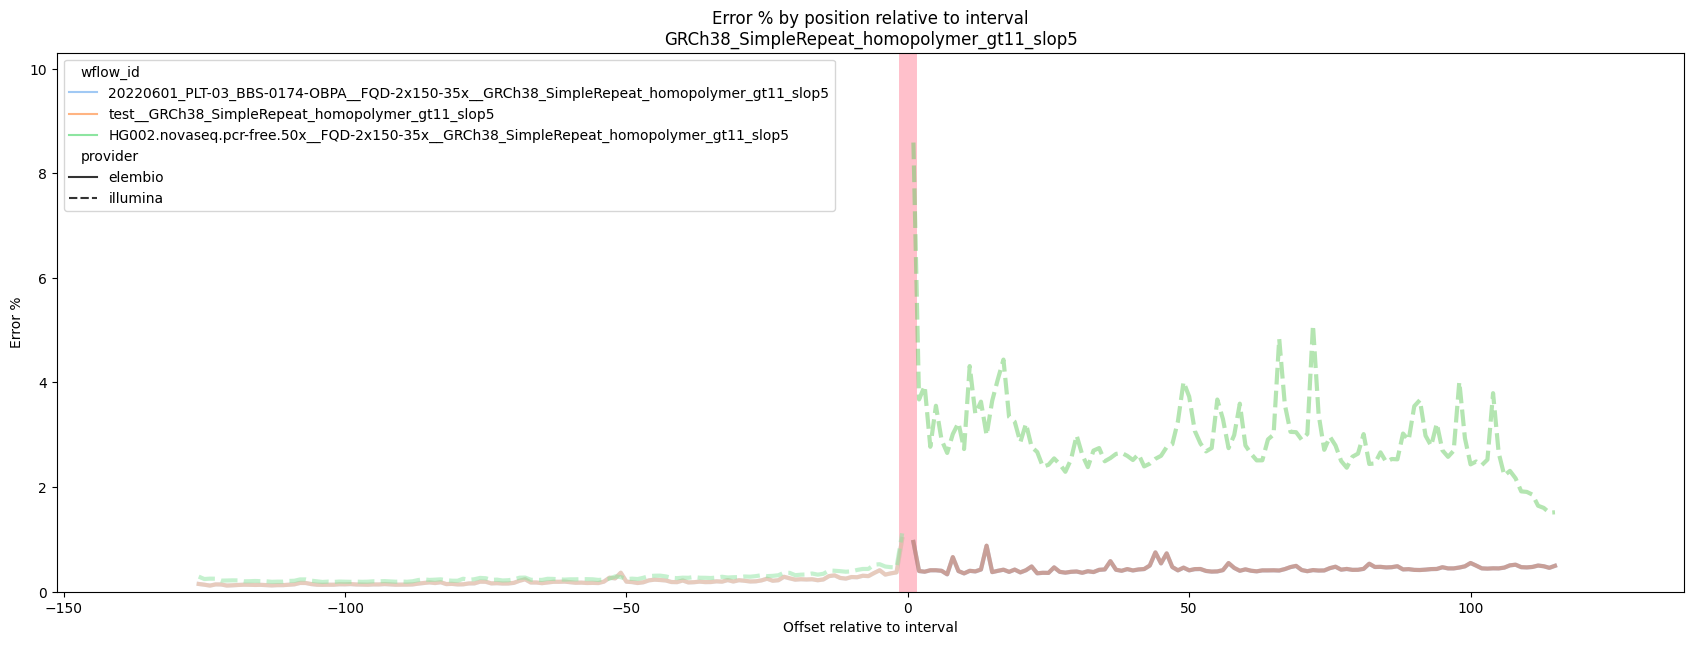

In [118]:
#offet error per workflow/run
#for run_shortname in set(offset_error_df["run_shortname"]):

    #pre_offset_error_df = offset_error_df[(offset_error_df.type == "pre") & (offset_error_df.run_shortname == run_shortname)]
    #post_offset_error_df = offset_error_df[(offset_error_df.type == "post") & (offset_error_df.run_shortname == run_shortname)]

    #print(run_shortname)

pre_offset_error_df = offset_error_df[(offset_error_df.type == "pre")]
post_offset_error_df = offset_error_df[(offset_error_df.type == "post")]

for hue in ["wflow_id"]:

    print(hue,sep="\t")
    
    style="provider"
    
    offset_error_df.to_excel(os.path.join(work_dir,f"offset-error__{catalog}__{hue}.xlsx"))

    fig, axs = plt.subplots(1,1,figsize=(21,7))

    n_hue = len(set(list(set(pre_offset_error_df[hue]))+list(set(post_offset_error_df[hue]))))

    ymax=max(max(pre_offset_error_df["error_rate"].dropna()*1.2),max(post_offset_error_df["error_rate"].dropna()*1.2))
    plt.ylim(0,ymax)

    sns.lineplot(data=pre_offset_error_df, x="pos", y="error_rate", hue=hue, style=style, linewidth=3, alpha=0.5, markers=False, palette=sns.color_palette("pastel", n_hue))
    sns.lineplot(data=post_offset_error_df, x="pos", y="error_rate", hue=hue, style=style, linewidth=3, alpha=0.5, markers=False, legend=False, palette=sns.color_palette("muted", n_hue))

    axs.set_title(f'Error % by position relative to interval\n{catalog}')
    axs.set_xlabel('Offset relative to interval')
    axs.set_ylabel('Error %')

    plt.xlim(min(pre_offset_error_df["pos"])*1.2,max(post_offset_error_df["pos"])*1.2)

    axs.add_patch(patches.Rectangle((-1, 0), 2, ymax,
                 edgecolor = 'pink',
                 facecolor = 'pink',
                 fill=True,
                 lw=5))

    plt.savefig(os.path.join(work_dir,f"offset-error__{catalog}__{hue}.png"),dpi=300,format='png',facecolor="w",bbox_inches="tight")
    if pdf:
        plt.savefig(os.path.join(work_dir,f"offset-error__{catalog}__{hue}.pdf"),dpi=300,format='pdf',facecolor="w",bbox_inches="tight")

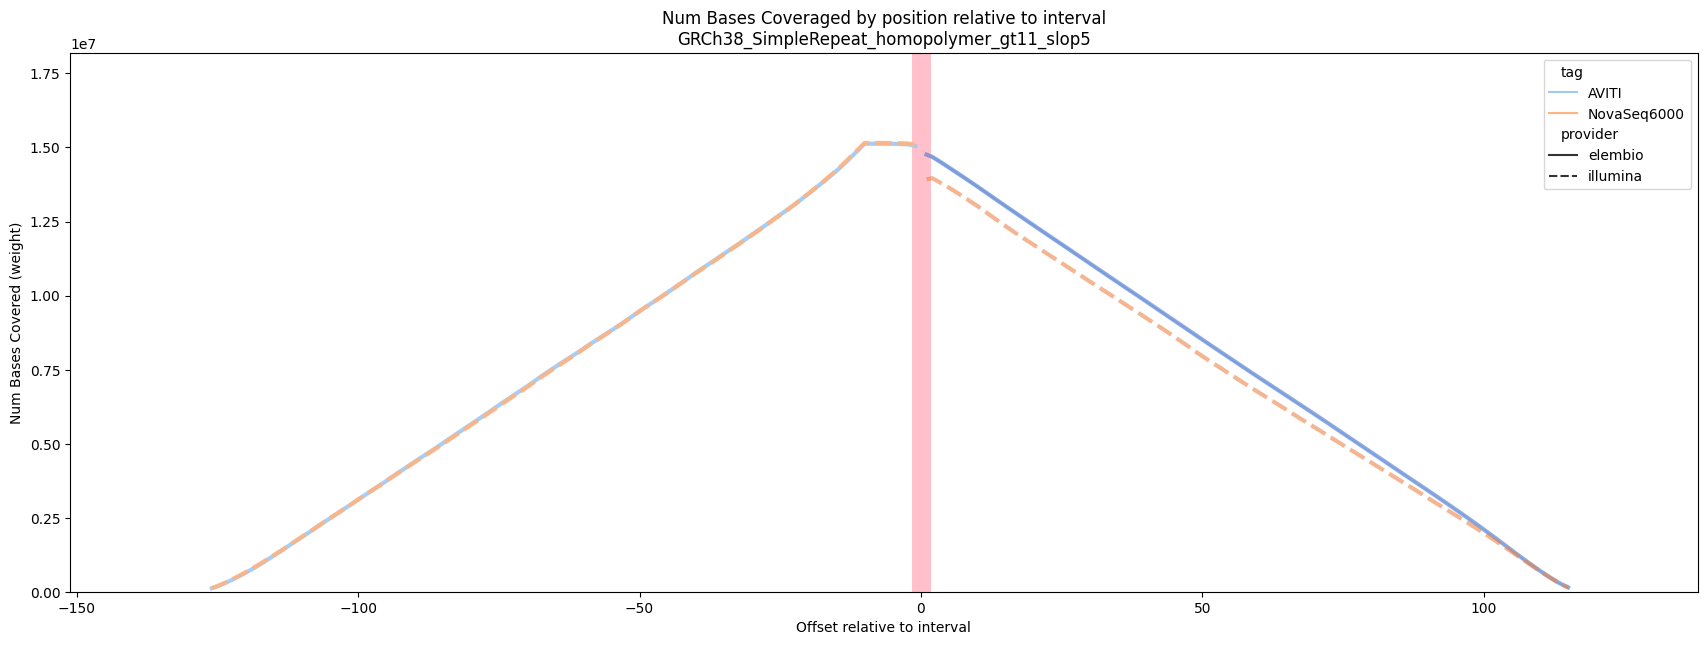

In [113]:
#offet coverage

pre_offset_error_df = offset_error_df[offset_error_df["type"] == "pre"]
post_offset_error_df = offset_error_df[offset_error_df["type"] == "post"]

for hue in ["tag"]:

    fig, axs = plt.subplots(1,1,figsize=(21,7))
    
    style="provider"

    n_hue = len(set(offset_error_df[hue]))

    sns.lineplot(data=pre_offset_error_df, x="pos", y="weight", hue=hue, style=style, linewidth=3, alpha=0.9, markers=False, palette=sns.color_palette("pastel", n_hue))
    sns.lineplot(data=post_offset_error_df, x="pos", y="weight", hue=hue, style=style, linewidth=3, alpha=0.6, markers=False, legend=False, palette=sns.color_palette("muted", n_hue))

    axs.set_title(f'Num Bases Coveraged by position relative to interval\n{catalog}')
    axs.set_xlabel('Offset relative to interval')
    axs.set_ylabel('Num Bases Covered (weight)')

    ymax=max([3,max(pre_offset_error_df["weight"]*1.2),max(post_offset_error_df["weight"]*1.2)])
    plt.ylim(0,ymax)
    plt.xlim(min(pre_offset_error_df["pos"])*1.2,max(post_offset_error_df["pos"])*1.2)

    axs.add_patch(patches.Rectangle((-1, 0), 2, ymax,
                 edgecolor = 'pink',
                 facecolor = 'pink',
                 fill=True,
                 lw=5))

    plt.savefig(os.path.join(work_dir,f"offset-weight__{catalog}__{hue}.png"),dpi=300,format='png',facecolor="w",bbox_inches="tight")
    if pdf:
        plt.savefig(os.path.join(work_dir,f"offset-weight__{catalog}__{hue}.pdf"),dpi=300,format='pdf',facecolor="w",bbox_inches="tight")

In [114]:
interval_error_mean = interval_error_df.groupby(["wflow_id","interval_length","tag"]).mean().reset_index()
interval_error_count = interval_error_df.groupby(["wflow_id","interval_length","tag"]).count().reset_index()

valid_interval_lengths = set(interval_error_count[interval_error_count.interval_coord  > 70]["interval_length"])
print(valid_interval_lengths)

interval_error_df = interval_error_df[interval_error_df.interval_length.isin(valid_interval_lengths)]

{12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}


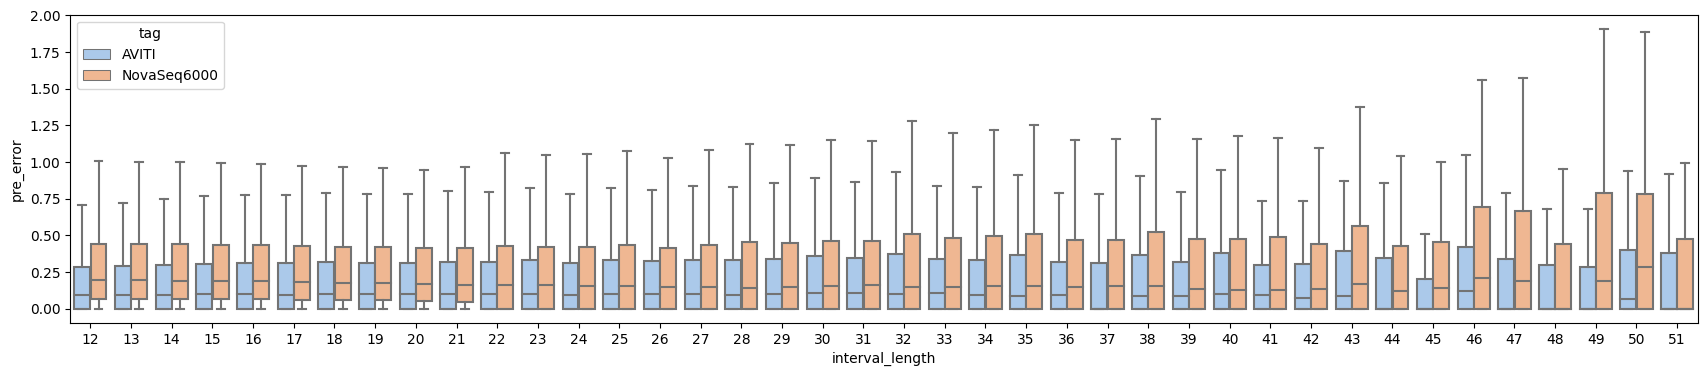

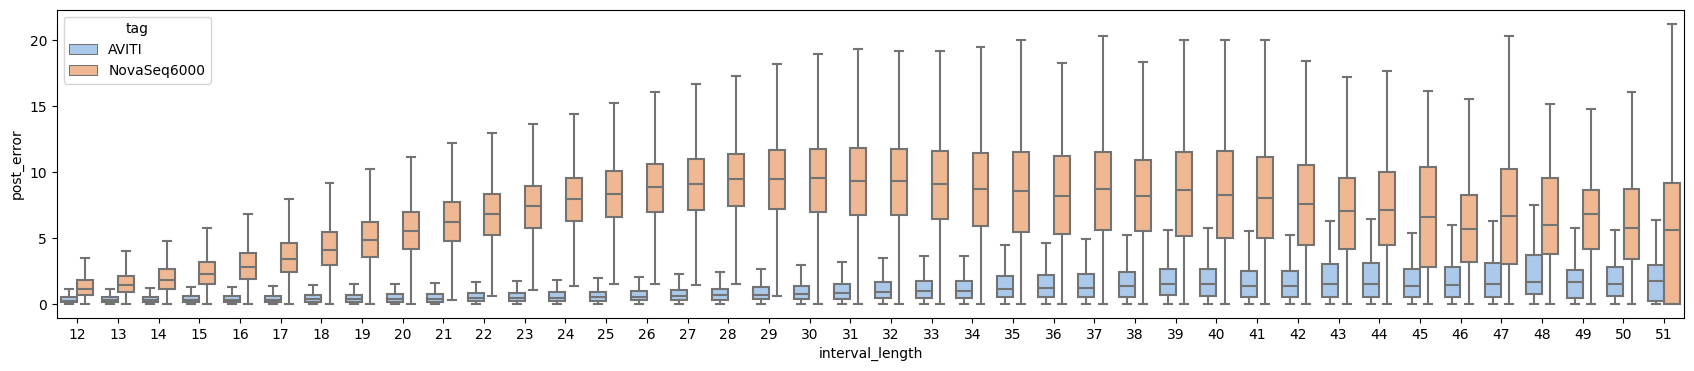

In [115]:
hue = "tag"

# pre error

fig, axs = plt.subplots(1,1,figsize=(21,4))

n_hue = len(set(interval_error_df[hue]))
sns.boxplot(data=interval_error_df, x="interval_length", y="pre_error", hue=hue, showfliers = False, palette=sns.color_palette("pastel", n_hue))

plt.savefig(os.path.join(work_dir,f"interval-error-by-length-box__pre-error__{catalog}__{hue}.png"),dpi=300,format='png',facecolor="w",bbox_inches="tight")
if pdf:
    plt.savefig(os.path.join(work_dir,f"interval-error-by-length-box__pre-error__{catalog}__{hue}.pdf"),dpi=300,format='pdf',facecolor="w",bbox_inches="tight")

# post error

fig, axs = plt.subplots(1,1,figsize=(21,4))
n_hue = len(set(interval_error_df[hue]))
sns.boxplot(data=interval_error_df, x="interval_length", y="post_error", hue=hue, showfliers = False, palette=sns.color_palette("pastel", n_hue))

plt.savefig(os.path.join(work_dir,f"interval-error-by-length-box__post-error__{catalog}__{hue}.png"),dpi=300,format='png',facecolor="w",bbox_inches="tight")
if pdf:
    plt.savefig(os.path.join(work_dir,f"interval-error-by-length-box__post-error_{catalog}__{hue}.pdf"),dpi=300,format='pdf',facecolor="w",bbox_inches="tight")

In [116]:
# group and divide by provider
providers = set(interval_error_df['provider'])

# seperate by provider
elembio_interval_error_df = interval_error_df[interval_error_df["tag"] == "AVITI"].reset_index()
illumina_interval_error_df = interval_error_df[interval_error_df["tag"] == "NovaSeq6000"].reset_index()

# get shared intervals
elembio_intervals = set(elembio_interval_error_df["interval_coord"])
illumina_intervals = set(illumina_interval_error_df["interval_coord"])
minimal_intervals = set.intersection(elembio_intervals, illumina_intervals)

print(f"shared intervals: {len(minimal_intervals)}")

# subset both down by minimal interval (shared) list)
elembio_interval_error_df = elembio_interval_error_df[elembio_interval_error_df["interval_coord"].isin(minimal_intervals)]
illumina_interval_error_df = illumina_interval_error_df[illumina_interval_error_df["interval_coord"].isin(minimal_intervals)]

# merge two DFs, drop extra columns
combined_interval_error_df = pd.merge(elembio_interval_error_df.drop(["level_0","wflow_id","provider","tag"],axis=1),illumina_interval_error_df[['interval_coord','pre_coverage','pre_mismatch','pre_base','pre_error','post_coverage','post_mismatch','post_base','post_error']],on='interval_coord', how='left', suffixes=["_elembio","_illumina"])

# compute error difference (pre/post)
combined_interval_error_df["pre_error_difference"] = combined_interval_error_df["pre_error_elembio"] - combined_interval_error_df["pre_error_illumina"]
combined_interval_error_df["post_error_difference"] = combined_interval_error_df["post_error_elembio"] - combined_interval_error_df["post_error_illumina"]

# filter by min coverage
print(f"before coverage filter: {len(combined_interval_error_df)}")
min_coverage = 15
combined_interval_error_df = combined_interval_error_df[(combined_interval_error_df["pre_coverage_elembio"] >= min_coverage) &
                                                        (combined_interval_error_df["post_coverage_elembio"] >= min_coverage) &
                                                        (combined_interval_error_df["pre_coverage_illumina"] >= min_coverage) &
                                                        (combined_interval_error_df["post_coverage_illumina"] >= min_coverage)]
print(f"after coverage filter: {len(combined_interval_error_df)}")

# dump merged/sorted DF
combined_interval_error_df.to_csv(os.path.join(work_dir,f"interval-diff.csv"))

# extract example intervals at 5%, 50%, 95%
num_intervals = len(combined_interval_error_df)

shared intervals: 655574
before coverage filter: 1309835
after coverage filter: 1049867


pre_error 0-percentile: 63.031317300191354
post_error 0-percentile: 97.39314598896813
0.05	chr13:52403938-52403966
0.5	chr5:167589199-167589215
0.95	chr21:28984652-28984664


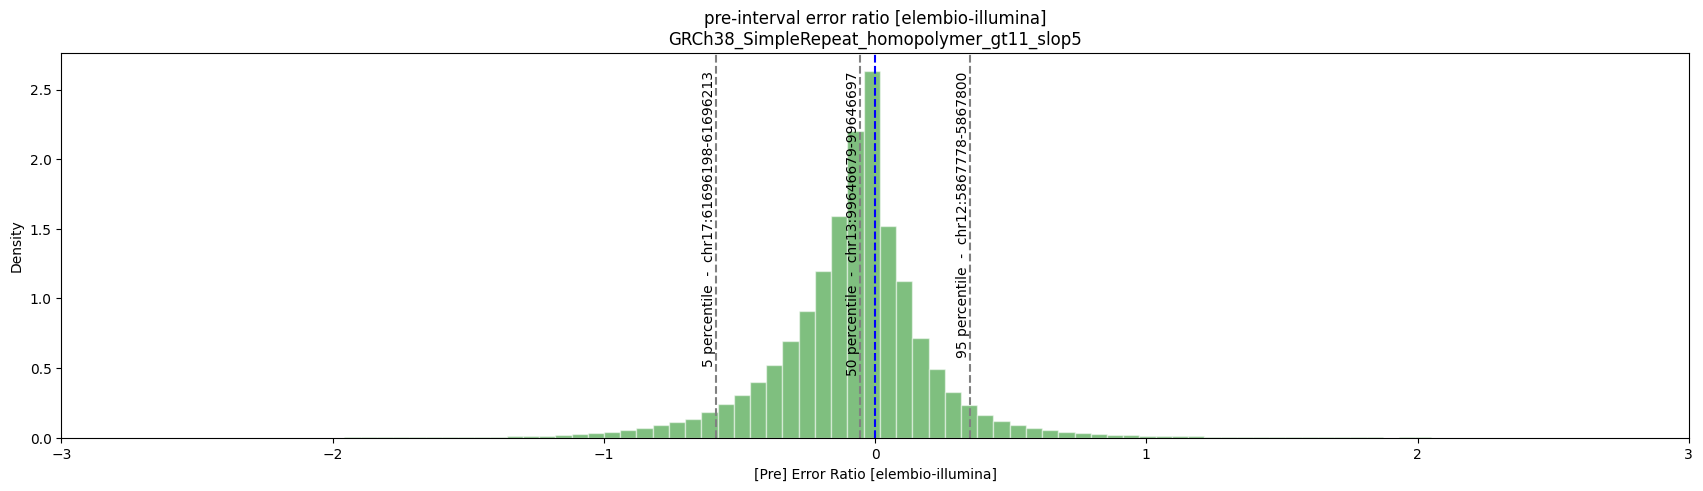

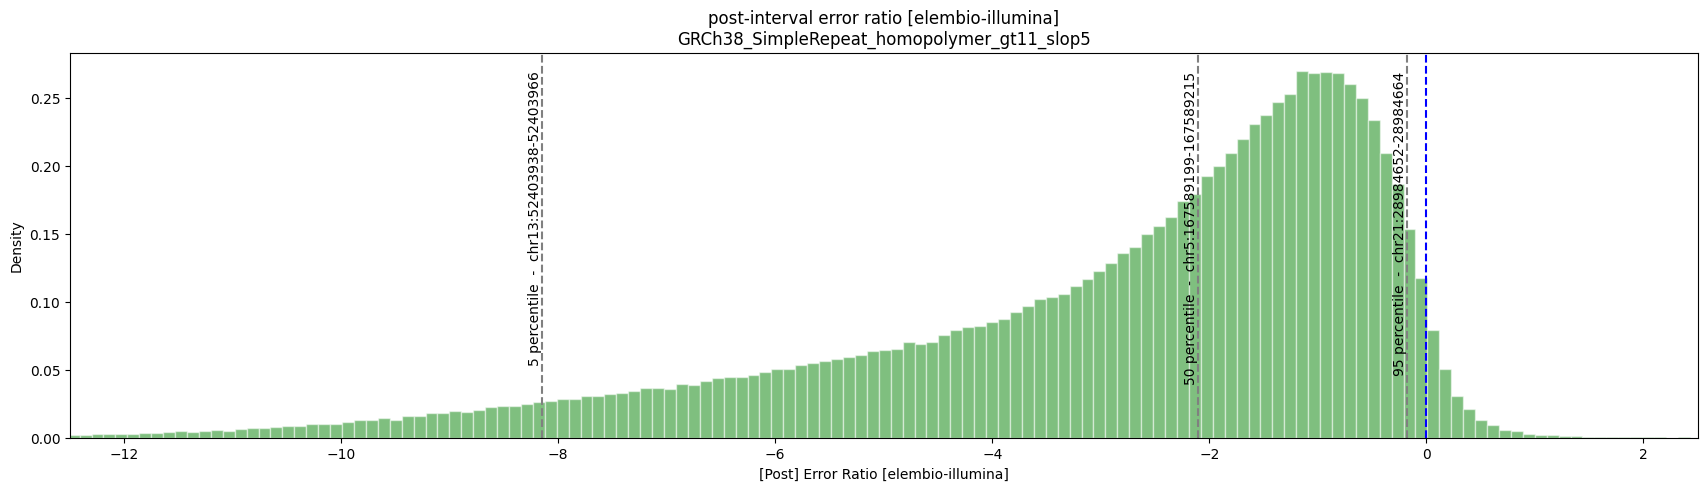

In [117]:

# plot error ratio
fig, axs = plt.subplots(1,1,figsize=(21,5))

# sort df by pre_error_difference
combined_interval_error_df = combined_interval_error_df.sort_values(by=['pre_error_difference'])
pre_zero_percentile = stats.percentileofscore(combined_interval_error_df["pre_error_difference"],0)
print(f"pre_error 0-percentile: {pre_zero_percentile}")

axs.set_title(f'pre-interval error ratio [elembio-illumina]\n{catalog}')
axs.set_xlabel('[Pre] Error Ratio [elembio-illumina]')
axs.set_ylabel('Density')
y, x, _ = plt.hist(combined_interval_error_df["pre_error_difference"], 300, density=True, facecolor='g', edgecolor='w', alpha=0.5)
plt.axvline(x=0, color='blue', linestyle='--')

# add percentile markers
for percentile in [0.05,0.5,0.95]:
    index = int(num_intervals*percentile)
    row = combined_interval_error_df.iloc[index]
    plt.axvline(x=row["pre_error_difference"], color='gray', linestyle='--')
    plt.text(row["pre_error_difference"],y.max(),str(int(percentile*100))+" percentile  -  "+row["interval_coord"],rotation=90, ha='right', va='top')

plt.xlim(-3,3)

plt.savefig(os.path.join(work_dir,f"interval-diff__pre__{catalog}.png"),dpi=300,format='png',facecolor="w",bbox_inches="tight")
if pdf:
    plt.savefig(os.path.join(work_dir,f"interval-diff__pre__{catalog}.pdf"),dpi=300,format='pdf',facecolor="w",bbox_inches="tight")


# post interval
fig, axs = plt.subplots(1,1,figsize=(21,5))

# sort df by post_error_difference
combined_interval_error_df = combined_interval_error_df.sort_values(by=['post_error_difference'])
post_zero_percentile = stats.percentileofscore(combined_interval_error_df["post_error_difference"],0)
print(f"post_error 0-percentile: {post_zero_percentile}")

axs.set_title(f'post-interval error ratio [elembio-illumina]\n{catalog}')
axs.set_xlabel('[Post] Error Ratio [elembio-illumina]')
axs.set_ylabel('Density')
y, x, _ = plt.hist(combined_interval_error_df["post_error_difference"], 300, density=True, facecolor='g', edgecolor='w', alpha=0.5)
plt.axvline(x=0, color='blue', linestyle='--')

# add percentile markers
for percentile in [0.05,0.5,0.95]:

    index = int(num_intervals*percentile)
    row = combined_interval_error_df.iloc[index]
    print(percentile, row["interval_coord"], sep="\t")

    plt.axvline(x=row["post_error_difference"], color='gray', linestyle='--')
    plt.text(row["post_error_difference"],y.max(),str(int(percentile*100))+" percentile  -  "+row["interval_coord"],rotation=90, ha='right', va='top')

plt.xlim(-12.5,2.5)

plt.savefig(os.path.join(work_dir,f"interval-diff__post__{catalog}.png"),dpi=300,format='png',facecolor="w",bbox_inches="tight")
if pdf:
    plt.savefig(os.path.join(work_dir,f"interval-diff__post__{catalog}.pdf"),dpi=300,format='pdf',facecolor="w",bbox_inches="tight")